This notebook trains various ML Models on Coughvid Dataset using PyCaret

Process :-

1. Loads Data
2. Uses Mild and Severe Labels to train
3. Downsamples Majority (Mild) class    
4. Extracts mfcc features
5. Uses Data Augmentation
6. Trains Various ML Models using Pycaret

Get Audio Data Zip File -> https://drive.google.com/file/d/1U1xn0qzPJmduHgPQL-oCrhW17Fjkdow9/view?usp=sharing

Get Audio Metadata File -> https://drive.google.com/file/d/15IGvBgdSImJJnw7o1P43JzeCfJkMVo8R/view?usp=sharing


In [1]:
!pip install pydub
!pip install audiomentations
!pip install librosa
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 57.7 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.0.post2
    Uninstalling librosa-0.10.0.post2:
      Successfully uninstalled librosa-0.10.0.post2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import os
import numpy as np
import IPython.display as ipd
import librosa
import librosa.display
from audiomentations import Compose, AddGaussianNoise, PitchShift, HighPassFilter
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# upload cleaned_dataset.zip to gdrive
# upload cleaned_coughvid_data.csv to gdrive

In [3]:
!unzip /content/drive/MyDrive/coughvid_cnn/cleaned_dataset.zip > /dev/null

In [4]:
cough_audio_data_path = "/content/cleaned_dataset"

In [5]:
features_path = "/content/drive/MyDrive/coughvid_cnn/cleaned_coughvid_data.csv"

In [6]:
import pandas as pd
df = pd.read_csv(features_path)
df.head()

,uuid,cough_detected,age,gender,respiratory_condition,fever_muscle_pain,status,status_SSL,cough_type,dyspnea,wheezing,stridor,choking,congestion,nothing,diagnosis,severity
0,01567151-7bb2-45ee-9aa8-a1332b5941ea,0.9820,NaN,NaN,NaN,NaN,NaN,NaN,dry,False,False,False,True,False,False,COVID-19,mild
1,018b40a1-c109-459a-9e31-86cbd2cb3918,0.9869,NaN,NaN,NaN,NaN,NaN,NaN,wet,False,False,False,False,False,True,lower_infection,mild
2,01ff40e8-63e6-4570-a463-9778ea30cad7,0.9686,24.0,other,False,False,symptomatic,NaN,dry,False,False,False,False,False,True,healthy_cough,pseudocough
3,0379c586-c500-483c-83a6-95b63afe6931,0.9916,63.0,male,True,False,COVID-19,NaN,dry,False,False,False,False,False,True,healthy_cough,pseudocough
4,038592cb-c8db-4f55-8052-e20059146cb5,0.9824,28.0,male,False,False,healthy,NaN,dry,False,False,False,False,False,True,COVID-19,mild


In [7]:
df.shape

(2587, 17)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2587 entries, 0 to 2586
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   2587 non-null   object 
 1   cough_detected         2587 non-null   float64
 2   age                    2180 non-null   float64
 3   gender                 2317 non-null   object 
 4   respiratory_condition  2317 non-null   object 
 5   fever_muscle_pain      2317 non-null   object 
 6   status                 2317 non-null   object 
 7   status_SSL             1078 non-null   object 
 8   cough_type             2587 non-null   object 
 9   dyspnea                2587 non-null   bool   
 10  wheezing               2587 non-null   bool   
 11  stridor                2587 non-null   bool   
 12  choking                2587 non-null   bool   
 13  congestion             2587 non-null   bool   
 14  nothing                2587 non-null   bool   
 15  diag

In [9]:
label_column = "severity"

In [10]:
df[label_column].value_counts()

mild           1691
pseudocough     526
severe          230
unknown         138
Name: severity, dtype: int64

In [11]:
df.drop(df.loc[df['severity']=="unknown"].index, inplace=True)
df.drop(df.loc[df['severity']=="pseudocough"].index, inplace=True)

In [12]:
df[label_column].value_counts()

mild      1691
severe     230
Name: severity, dtype: int64

In [13]:
df["severity"] = df["severity"].fillna("")
df.drop(df.loc[df['severity']==""].index, inplace=True)

In [14]:
len(df)

1921

In [15]:
severity_label_map = {"mild":0, "severe": 1}
df = df.replace({"severity": severity_label_map})

In [16]:
df

,uuid,cough_detected,age,gender,respiratory_condition,fever_muscle_pain,status,status_SSL,cough_type,dyspnea,wheezing,stridor,choking,congestion,nothing,diagnosis,severity
0,01567151-7bb2-45ee-9aa8-a1332b5941ea,0.9820,NaN,NaN,NaN,NaN,NaN,NaN,dry,False,False,False,True,False,False,COVID-19,0
1,018b40a1-c109-459a-9e31-86cbd2cb3918,0.9869,NaN,NaN,NaN,NaN,NaN,NaN,wet,False,False,False,False,False,True,lower_infection,0
4,038592cb-c8db-4f55-8052-e20059146cb5,0.9824,28.0,male,False,False,healthy,NaN,dry,False,False,False,False,False,True,COVID-19,0
7,0569d979-384b-4a30-b0ca-2b19e8c8650b,0.9781,26.0,male,False,True,symptomatic,NaN,wet,False,False,False,False,False,True,lower_infection,0
8,06e9197b-9b40-4bde-bde8-9e78242a60ac,0.9952,33.0,female,False,False,symptomatic,NaN,dry,False,False,False,False,False,True,COVID-19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2581,febc1922-0a6f-4667-8f5a-d28efdcd993d,0.9591,33.0,male,False,True,symptomatic,NaN,dry,False,False,False,False,False,True,COVID-19,0
2582,fed255ec-4829-4f4a-b22d-9bb23f2dd89f,0.9502,NaN,NaN,NaN,NaN,NaN,COVID-19,dry,False,False,False,False,False,True,upper_infection,0
2583,ff1234d7-7837-4ba7-842f-99fdc916baa9,0.9947,29.0,male,False,True,symptomatic,NaN,dry,False,False,False,False,False,True,upper_infection,0
2584,ff8363d2-016d-4738-9499-4c62480886fb,0.9933,NaN,female,False,False,COVID-19,NaN,dry,False,False,False,False,False,True,COVID-19,0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1921 entries, 0 to 2585
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   1921 non-null   object 
 1   cough_detected         1921 non-null   float64
 2   age                    1624 non-null   float64
 3   gender                 1728 non-null   object 
 4   respiratory_condition  1728 non-null   object 
 5   fever_muscle_pain      1728 non-null   object 
 6   status                 1728 non-null   object 
 7   status_SSL             747 non-null    object 
 8   cough_type             1921 non-null   object 
 9   dyspnea                1921 non-null   bool   
 10  wheezing               1921 non-null   bool   
 11  stridor                1921 non-null   bool   
 12  choking                1921 non-null   bool   
 13  congestion             1921 non-null   bool   
 14  nothing                1921 non-null   bool   
 15  diag

In [18]:
ndf = df[["uuid","severity"]]

In [19]:
ndf.sample(5)

,uuid,severity
1326,3722d824-c4bc-489d-8a8f-6bb171129e19,0
1401,570acf17-56d0-423e-869f-38cc0360d5e7,0
551,fd7d172d-4106-427a-870b-0384c88f147f,0
1873,0ebb8b25-3a7e-4018-81c6-c93c832fa769,0
16,0b618a49-9562-4fa5-afb7-fce583b5a444,0


In [20]:
X = ndf.drop(["severity"], axis=1)
y = ndf["severity"]

In [21]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [22]:
print(X_train.shape,y_train.shape)

(1344, 1) (1344,)


In [23]:
print(X_test.shape,y_test.shape)

(577, 1) (577,)


In [24]:
df_train = X_train.assign(severity = y_train)
df_train.head()

,uuid,severity
975,ad4e4752-2168-4138-a5b8-a07c0332a921,0
1446,66bd4211-2034-4cde-82ad-59aeff6e7eb8,0
633,2ca9e925-859f-417e-838b-681d77639839,0
86,2cc30bb4-6e0f-4cb5-a7a5-f7fa03c203ba,0
1625,ae4b17b8-7b3f-434a-a894-d4257c7394f5,0


In [25]:
df_train.severity.value_counts()

0    1176
1     168
Name: severity, dtype: int64

In [26]:
df_test = X_test.assign(severity = y_test)
df_test.head()

,uuid,severity
495,de67d064-eff4-40c4-ab46-b115d0691e1f,0
2035,47ceafde-45d9-4bb6-881a-5ef866fa908d,0
1638,b37a051e-c2b0-4f38-9b12-51652c511d03,0
2145,6e777752-cb40-47dd-ae97-50bc73da4550,0
587,154161ff-1243-49c0-a377-72992b6954e3,0


In [27]:
df_test.severity.value_counts()

0    515
1     62
Name: severity, dtype: int64

In [28]:
#Separate the majority and minority class
df_majority = df_train[df_train["severity"] == 0]
df_minority = df_train[df_train["severity"] == 1]

print(df_majority["severity"].value_counts())
print(df_minority["severity"].value_counts())

0    1176
Name: severity, dtype: int64
1    168
Name: severity, dtype: int64


In [29]:
from sklearn.utils import resample
# Downsample majority class
df_majority_downsampled = resample(df_majority,replace=False,n_samples=250)

In [33]:
#Upsample minority class -> leads to data deduplication -> Not done
#df_minority_upsampled = resample(df_minority,replace=True,n_samples=250)

In [30]:
# Combine minority class with downsampled majority class
df_up_down_sampled = pd.concat([df_majority_downsampled, df_minority])
df_up_down_sampled["severity"].value_counts()

0    250
1    168
Name: severity, dtype: int64

In [31]:
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=10)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    return mfccs_scaled_features

In [32]:
# Raw audio augmentation
severe_augments = Compose(
    [
        AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.015, p=0.2),
        PitchShift(min_semitones=-8, max_semitones=8, p=0.7),
        HighPassFilter(min_cutoff_freq=2000, max_cutoff_freq=4000, p=0.7)
    ]
)


# Raw audio augmentation
mild_augments = Compose(
    [
        AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.015, p=0.2),
        PitchShift(min_semitones=-8, max_semitones=8, p=0.5),
        HighPassFilter(min_cutoff_freq=2000, max_cutoff_freq=4000, p=0.6)
    ]
)

In [33]:
def augment_features_extractor(file_name,label_name):
    audio, sample_rate = librosa.load(file_name)
    if label_name == 1:
        augmented_signal = severe_augments(audio, sample_rate)
    else:
        augmented_signal = mild_augments(audio, sample_rate)

    mfccs_features = librosa.feature.mfcc(y=augmented_signal, sr=sample_rate, n_mfcc=10)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    return mfccs_scaled_features

In [34]:
import numpy as np
from tqdm import tqdm
import random
extracted_features=[]
for index_num,row in tqdm(df_up_down_sampled.iterrows()):
    file_name = os.path.join(cough_audio_data_path,str(row["uuid"])+".wav")
    final_class_labels=row["severity"]

    if final_class_labels == 0:
        rand_num1 = random.randint(0,10)
        if rand_num1 % 2 != 0:
            a_mfcc = augment_features_extractor(file_name,final_class_labels)
            extracted_features.append([a_mfcc[0],a_mfcc[1],a_mfcc[2],a_mfcc[3],a_mfcc[4],\
                                        a_mfcc[5],a_mfcc[6],a_mfcc[7],a_mfcc[8],a_mfcc[9],\
                                        final_class_labels])
        else:
            mfcc = features_extractor(file_name)
            extracted_features.append([mfcc[0],mfcc[1],mfcc[2],mfcc[3],mfcc[4],\
                                        mfcc[5],mfcc[6],mfcc[7],mfcc[8],mfcc[9],\
                                        final_class_labels])

    if final_class_labels == 1:
        rand_num2 = random.randint(0, 10)
        if rand_num1 % 2 != 0:
            a_mfcc = augment_features_extractor(file_name,final_class_labels)
            extracted_features.append([a_mfcc[0],a_mfcc[1],a_mfcc[2],a_mfcc[3],a_mfcc[4],\
                                        a_mfcc[5],a_mfcc[6],a_mfcc[7],a_mfcc[8],a_mfcc[9],\
                                        final_class_labels])
        else:
            mfcc = features_extractor(file_name)
            extracted_features.append([mfcc[0],mfcc[1],mfcc[2],mfcc[3],mfcc[4],\
                                        mfcc[5],mfcc[6],mfcc[7],mfcc[8],mfcc[9],\
                                        final_class_labels])


418it [04:01,  1.73it/s]


In [35]:
### converting extracted_features to Pandas dataframe
extracted_features_df = pd.DataFrame(extracted_features,columns=['mfcc1','mfcc2','mfcc3','mfcc4','mfcc5',\
                                                                 'mfcc6','mfcc7','mfcc8','mfcc9','mfcc10',\
                                                                 'severity'])
extracted_features_df.head(10)

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,severity
0,-504.591125,26.716600,-15.628798,9.373886,-9.589803,4.525829,-4.183209,-3.785188,-3.669159,-0.850862,0
1,-173.502441,21.434629,-9.883523,-2.485516,-7.842629,-3.377445,-6.662353,-8.332465,-4.521680,-5.024732,0
2,-467.362701,42.548370,-12.235063,18.105247,-9.240889,7.436808,-12.452253,-0.782396,1.263024,1.012801,0
3,-586.293762,-6.500535,-43.055454,5.736167,-19.693535,14.595145,-10.173069,1.999512,-9.591156,-3.063178,0
4,-463.193024,49.076237,-23.824057,7.867062,-24.664303,10.513648,-13.680523,-4.191961,-11.280830,-8.789691,0
5,-546.857422,19.137943,-10.202560,0.007289,-7.206754,1.941413,-7.189895,2.131445,-7.170064,0.697901,0
6,-437.885834,79.541901,7.371029,16.629267,-12.567167,7.420761,-13.376069,-13.253537,-6.804330,-6.507085,0
7,-411.004761,46.499741,5.193713,8.810419,6.864319,8.877063,1.932977,8.576390,-6.974819,2.645244,0
8,-480.015808,25.844904,-9.627275,1.115276,-4.052515,4.683749,-3.294228,-3.293206,-4.679850,-2.535253,0
9,-393.338837,79.566406,-25.049206,29.852900,-1.326833,8.259604,-2.675005,-2.113298,-5.102330,-2.189092,0


In [36]:
extracted_features_df.shape

(418, 11)

In [37]:
extracted_features_df.severity.value_counts()

0    250
1    168
Name: severity, dtype: int64

<Axes: >

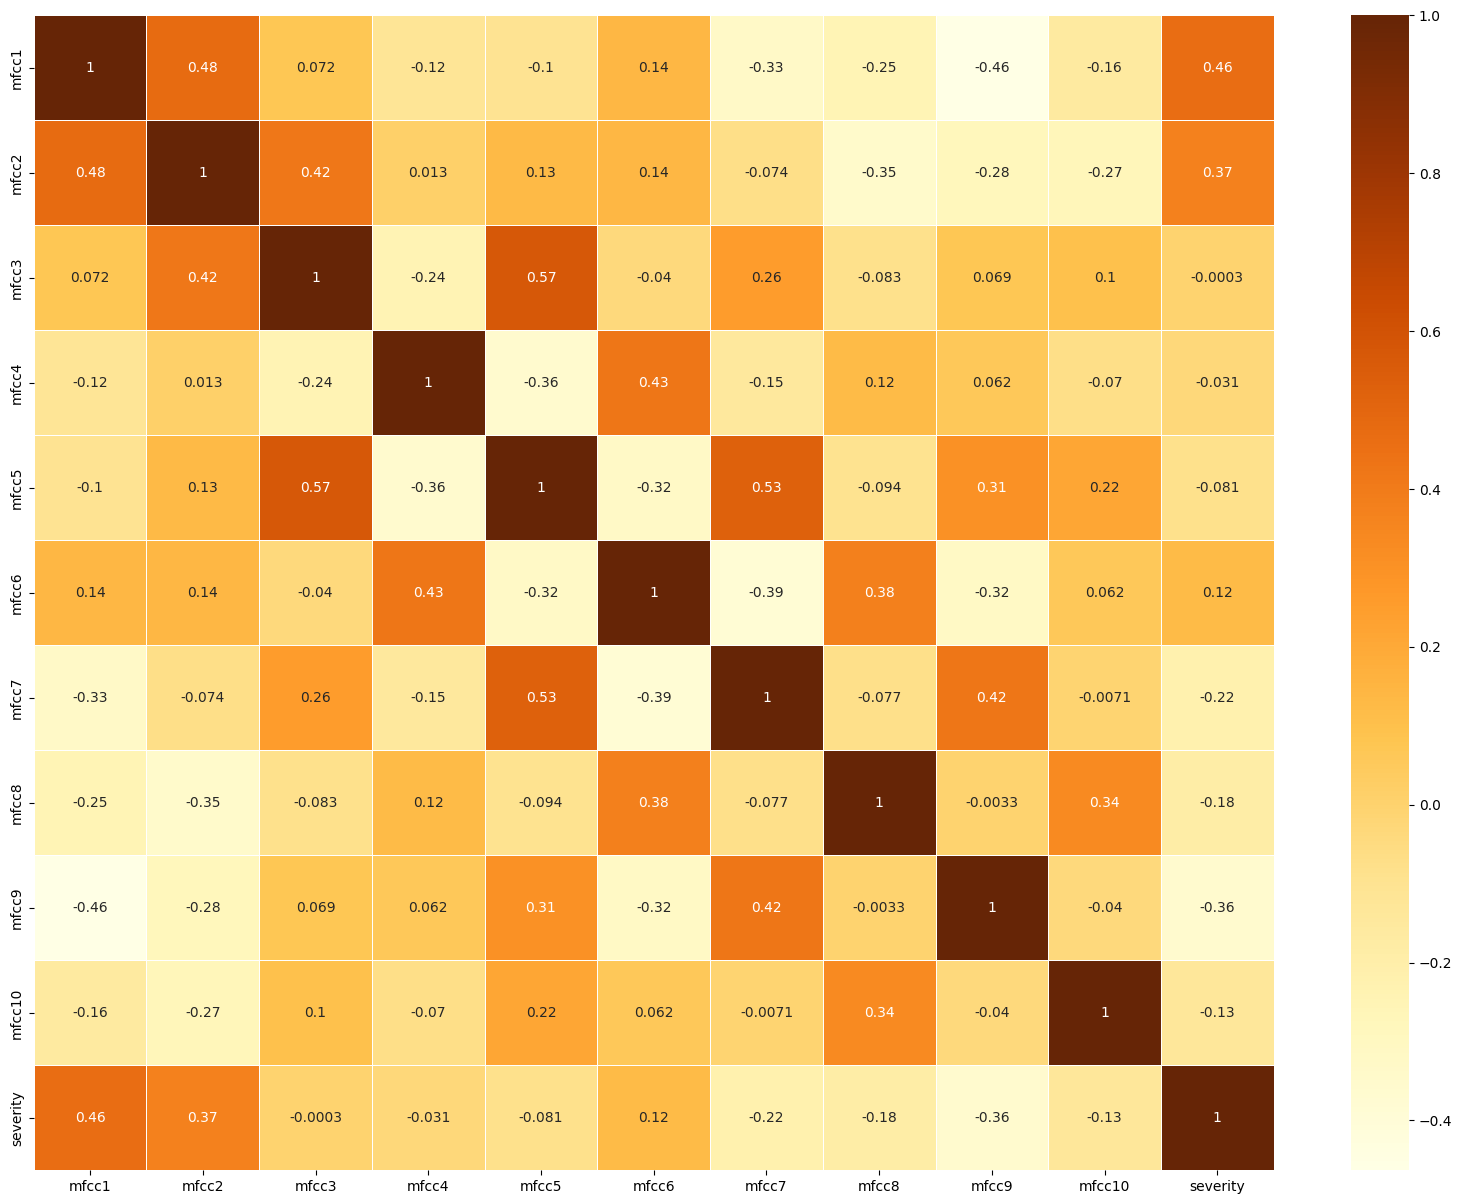

In [38]:
import seaborn as sns
plt.figure(figsize = (20,15))
sns.heatmap(data = extracted_features_df.corr(), cmap="YlOrBr", annot = True, linewidth = 0.5)

In [39]:
!pip install --pre pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.6/483.6 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB

In [40]:
from pycaret.classification import *

s = setup(extracted_features_df, target = 'severity')

,Description,Value
0,Session id,4644
1,Target,severity
2,Target type,Binary
3,Original data shape,"(418, 11)"
4,Transformed data shape,"(418, 11)"
5,Transformed train set shape,"(292, 11)"
6,Transformed test set shape,"(126, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


In [41]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7605,0.8130,0.6500,0.7426,0.6817,0.4931,0.5069,1.0110
rf,Random Forest Classifier,0.7568,0.7995,0.6409,0.7384,0.6739,0.4849,0.4976,1.1850
xgboost,Extreme Gradient Boosting,0.7499,0.7844,0.6583,0.6992,0.6755,0.4733,0.4761,0.1370
gbc,Gradient Boosting Classifier,0.7361,0.7974,0.6598,0.6859,0.6647,0.4505,0.4571,1.0610
nb,Naive Bayes,0.7257,0.7892,0.8129,0.6250,0.7039,0.4588,0.4753,0.0800
lightgbm,Light Gradient Boosting Machine,0.7226,0.7835,0.6076,0.6808,0.6329,0.4137,0.4228,0.2130
ada,Ada Boost Classifier,0.7157,0.7939,0.6159,0.6511,0.6210,0.3988,0.4073,0.5600
knn,K Neighbors Classifier,0.6953,0.7624,0.6341,0.6285,0.6225,0.3700,0.3771,0.1280
ridge,Ridge Classifier,0.6846,0.0000,0.5470,0.6173,0.5730,0.3281,0.3323,0.0820
lda,Linear Discriminant Analysis,0.6846,0.7702,0.5561,0.6151,0.5761,0.3300,0.3345,0.1060


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [42]:
finalize_model(best)

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['mfcc1', 'mfcc2', 'mfcc3', 'mfcc4',
                                             'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8',
                                             'mfcc9', 'mfcc10'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean',
                                                              verbose='deprecat...
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=None, max_features='sqrt',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=100, n_jobs=-1,
                                      oob_score=False, random_state=4644,
                                      verbose=0, warm_start=False))],
         verbose=False)

In [43]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [44]:
len(df_test)

577

In [45]:
df_test.severity.value_counts()

0    515
1     62
Name: severity, dtype: int64

In [46]:
import numpy as np
from tqdm import tqdm
import random
extracted_test_features = []
for index_num,row in tqdm(df_test.iterrows()):
    file_name = os.path.join(cough_audio_data_path,str(row["uuid"])+".wav")
    final_class_labels=row["severity"]
    mfcc = features_extractor(file_name)
    extracted_test_features.append([mfcc[0],mfcc[1],mfcc[2],mfcc[3],mfcc[4],\
                                    mfcc[5],mfcc[6],mfcc[7],mfcc[8],mfcc[9],\
                                    final_class_labels])

577it [05:25,  1.77it/s]


In [47]:
### converting extracted_features to Pandas dataframe
test_df = pd.DataFrame(extracted_test_features,columns=['mfcc1','mfcc2','mfcc3','mfcc4','mfcc5',\
                                                         'mfcc6','mfcc7','mfcc8','mfcc9','mfcc10',\
                                                         'severity'])
test_df.head(10)

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,severity
0,-397.859253,39.145794,-16.811817,4.172975,-8.636632,14.694258,-3.866268,3.766282,-0.686433,-3.324341,0
1,-439.847900,26.748205,-8.033614,9.888568,-13.840316,11.202400,-13.108004,-3.283462,-6.494425,-1.018818,0
2,-490.364288,10.623646,-9.252662,2.657977,2.630585,6.883135,2.209274,-3.937876,-0.952080,0.717999,0
3,-327.788055,55.230312,-34.861382,3.358336,-23.643570,5.652305,-23.807478,-16.792208,-22.399080,-10.890100,0
4,-458.735229,16.563782,-3.520684,6.052978,0.331115,-1.549231,-4.825337,-2.040216,-1.373108,-7.246084,0
5,-451.116028,47.152756,-0.079004,9.521749,-0.280528,9.147151,-19.079769,-9.826105,-12.944187,-3.958135,0
6,-505.479309,31.321623,-5.810166,3.068511,-5.724372,4.487230,-6.215856,-5.844991,-4.437447,-2.342747,0
7,-385.424011,57.962807,-3.301512,13.668096,-16.711107,6.195357,-11.985635,3.927076,-4.953614,-5.873332,0
8,-452.896210,53.932739,20.149427,10.177911,-2.431713,0.674765,0.700604,3.105813,1.941739,5.415751,0
9,-334.834778,55.588223,-37.413071,8.717346,-11.822326,12.179776,-11.516092,-7.995494,-9.794427,-0.513767,0


In [48]:
predict_model(best, test_df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7314,0.7272,0.6452,0.2312,0.3404,0.2165,0.2615


,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,severity,prediction_label,prediction_score
0,-397.859253,39.145794,-16.811817,4.172975,-8.636632,14.694258,-3.866268,3.766282,-0.686433,-3.324341,0,0,0.6250
1,-439.847900,26.748205,-8.033614,9.888568,-13.840316,11.202400,-13.108004,-3.283462,-6.494425,-1.018818,0,0,0.7700
2,-490.364288,10.623646,-9.252662,2.657977,2.630585,6.883135,2.209274,-3.937876,-0.952080,0.717999,0,0,0.8800
3,-327.788055,55.230312,-34.861382,3.358336,-23.643570,5.652305,-23.807478,-16.792208,-22.399080,-10.890100,0,1,0.7400
4,-458.735229,16.563782,-3.520684,6.052978,0.331115,-1.549231,-4.825337,-2.040216,-1.373108,-7.246084,0,0,0.9400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,-502.052032,25.417416,-11.381307,4.790165,-0.779624,2.812314,-4.656240,-2.226862,-6.427449,-0.674663,0,0,0.8300
573,-420.100311,52.905899,-10.177254,11.783190,-12.420751,0.351824,-6.254005,-8.028126,-11.479688,-3.549476,0,0,0.5533
574,-452.712769,61.654408,-7.468761,10.471319,-12.351452,3.369245,-16.374916,-7.570490,-13.583467,-1.842488,0,0,0.6700
575,-418.033661,59.834240,-17.386797,-0.866527,-5.739826,1.929993,-4.344738,-13.090132,-6.080495,-4.671775,0,1,0.6500


In [ ]:
#We might be able to use the model because of high recall -> which means it does better on the severe cases

In [49]:
X_train = extracted_features_df.drop(["severity"], axis=1)
y_train = extracted_features_df["severity"]

In [50]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import RandomForestClassifier
# Define the model
reg = RandomForestClassifier(criterion="gini", n_estimators=100, random_state=8147)
# Create a cross-validation object (in this example, using 5-fold cross-validation)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Perform cross-validation
scores = cross_val_score(reg, X_train, y_train, cv=kf, scoring='f1_weighted')
# Print the cross-validation scores
print("Cross-validation scores:", scores)
# Print the average cross-validation score
print("Weighted F1 score:", np.mean(scores))

Cross-validation scores: [0.7635582  0.7129781  0.73596059 0.7635582  0.72959184 0.70833333
 0.70822281 0.76190476 0.64317073 0.70731707]
Weighted F1 score: 0.7234595639188789


In [51]:
X_test = test_df.drop(["severity"], axis=1)
y_test = test_df["severity"]

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
reg = RandomForestClassifier(random_state=1574)
reg.fit(X_train, y_train)
y_test_pred = reg.predict(X_test)
f1_score(y_test, y_test_pred, average="weighted")

0.7664234508581447

In [53]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
# Define the model
reg = ExtraTreesClassifier(random_state=1574)
# Create a cross-validation object (in this example, using 5-fold cross-validation)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Perform cross-validation
scores = cross_val_score(reg, X_train,y_train, cv=kf, scoring='f1_weighted')
# Print the cross-validation scores
print("Cross-validation scores:", scores)
# Print the average cross-validation score
print("Weighted F1 score:", np.mean(scores))

Cross-validation scores: [0.69173955 0.71428571 0.68142579 0.71626984 0.76785714 0.71167048
 0.74022989 0.71697479 0.62147608 0.74921826]
Weighted F1 score: 0.7111147539892425


In [54]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score
reg = ExtraTreesClassifier(random_state=1574)
reg.fit(X_train, y_train)
y_test_pred = reg.predict(X_test)
f1_score(y_test, y_test_pred, average="weighted")

0.7586373772944549